<a href="https://colab.research.google.com/github/erikycd/Taller_visionM/blob/main/Stability_API_StableDif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando la API de Stability con Python
### Ejemplo extraido de: https://platform.stability.ai/docs/features

## Instalación rápida de las librerias de Stability SDK

In [1]:
%pip install stability-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.59.0
    Uninstalling grpcio-1.59.0:
      Successfully uninstalled grpcio-1.59.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.21.12 which is incompatible.


##Definiendo mi API key

In [2]:
import getpass, os

# Our Host URL should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://platform.stability.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://platform.stability.ai/account/keys

# Paste your API Key below after running this cell.

os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

Enter your API Key··········


##Conectando mi llave y definiendo el VM!

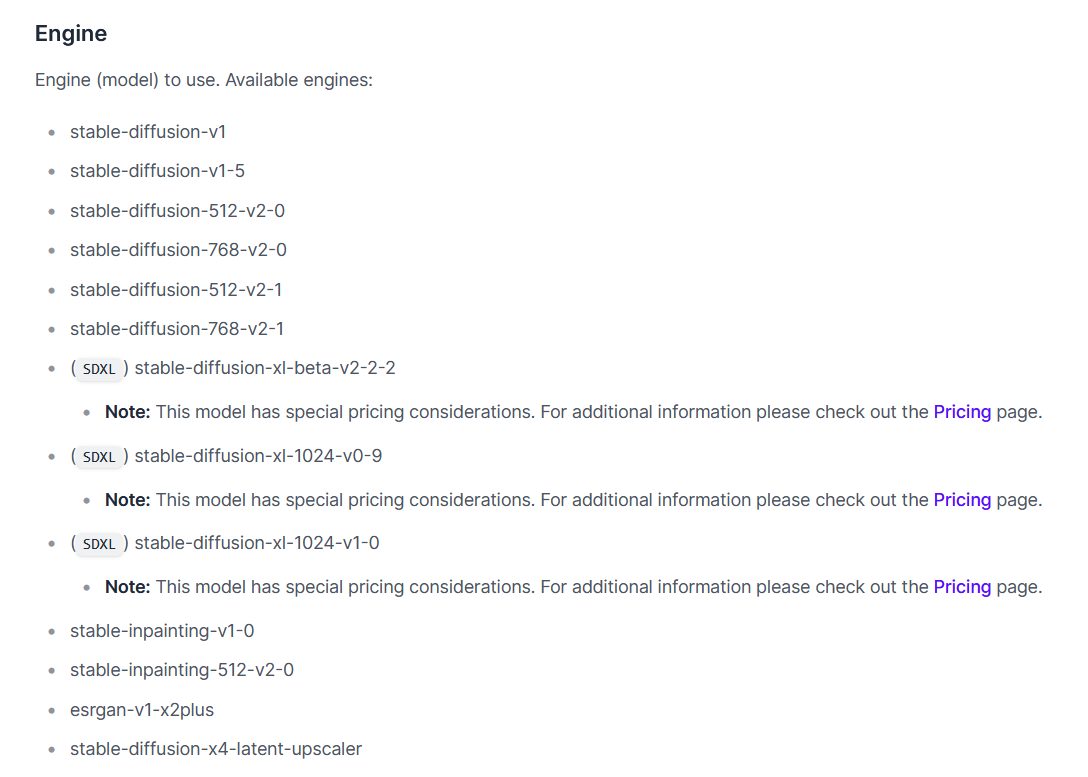

In [3]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

# Set up our connection to the API.
stability_api = client.StabilityInference(
    key = os.environ['STABILITY_KEY'], # API Key reference.
    verbose = True, # Print debug messages.
    engine = "stable-diffusion-512-v2-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


## Generando imagenes desde texto

### Descripción de los parámetros: https://platform.stability.ai/docs/features/api-parameters

In [4]:
# Set up our initial generation parameters.
answers = stability_api.generate(
    prompt = "A post-apocalyptic world of ash and destruction, with a volcano in the center, erupting with molten lava and smoke., ultra hd, realistic, vivid colors, highly detailed",
    seed = 4253978046, # If a seed is provided, the resulting generated image will be deterministic.
                     # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                     # Note: This isn't quite the case for Clip Guided generations, which we'll tackle in a future example notebook.
    steps = 50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale = 8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width = 512, # Generation width, defaults to 512 if not included.
    height = 512, # Generation height, defaults to 512 if not included.
    samples = 1, # Number of images to generate, defaults to 1 if not included.
    sampler = generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 58434c36-9c30-40e2-9e6b-53609e448095 in 0.39s
INFO:stability_sdk.client:Got keepalive 58434c36-9c30-40e2-9e6b-53609e448095 in 3.94s
INFO:stability_sdk.client:Got answer 58434c36-9c30-40e2-9e6b-53609e448095 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.46s


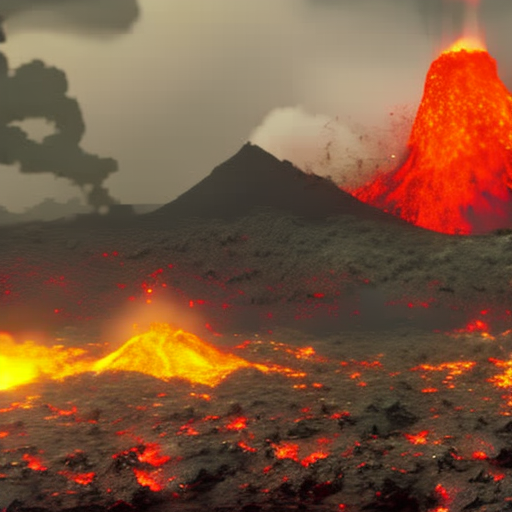

In [5]:
# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, save generated images.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

In [8]:
img.save('imagen_volcano.png')

## Conectando mi API para generar variaciones de una imágen

In [7]:
# Set up our initial generation parameters.
answers2 = stability_api.generate(
    prompt = "A crayon drawing of a volcano erupting with molten lava and smoke, sunset ambient, Fish-eye style",
    init_image = img, # Assign our previously generated img as our Initial Image for transformation.
    start_schedule = 0.6, # Set the strength of our prompt in relation to our initial image.
    seed = 123463446, # If attempting to transform an image that was previously generated with our API,
                    # initial images benefit from having their own distinct seed rather than using the seed of the original image generation.
    steps = 50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale = 8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width = 512, # Generation width, defaults to 512 if not included.
    height = 512, # Generation height, defaults to 512 if not included.
    sampler = generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)


INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive fd518c11-2ac3-4d74-a925-37cddb4601b9 in 0.49s
INFO:stability_sdk.client:Got keepalive fd518c11-2ac3-4d74-a925-37cddb4601b9 in 3.95s
INFO:stability_sdk.client:Got answer fd518c11-2ac3-4d74-a925-37cddb4601b9 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.47s


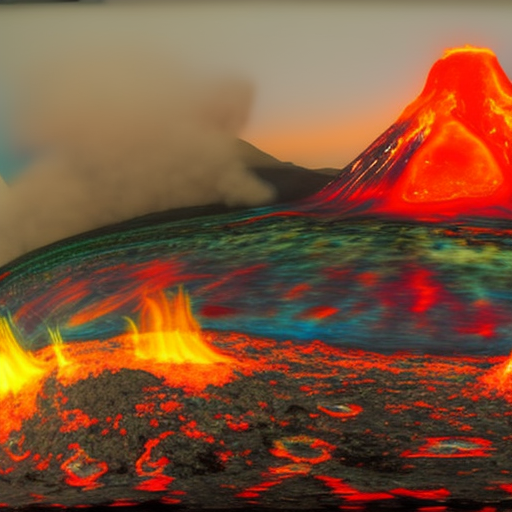

In [9]:
# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, save generated image.
for resp in answers2:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

In [11]:
img2.save('imagen_volcano2.png')

## Mostrando las imágenes

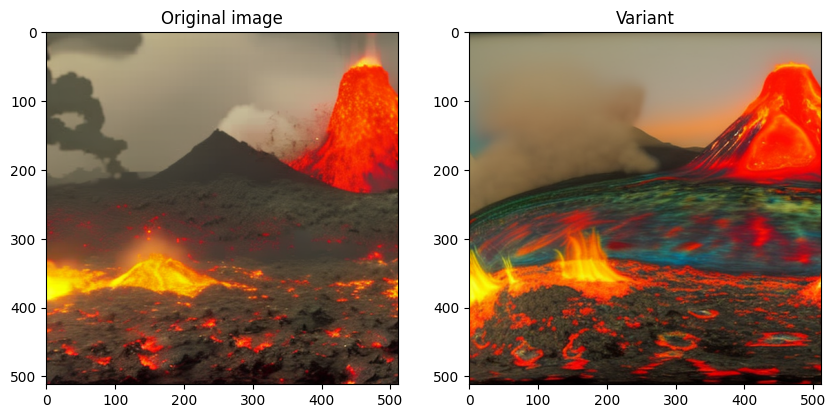

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura según tus necesidades
plt.subplot(1, 2, 1)  # Subtrama 1
plt.imshow(img)
plt.title('Original image')

plt.subplot(1, 2, 2)  # Subtrama 2
plt.imshow(img2)
plt.title('Variant')

plt.show()
